In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [1]:
import pandas as pd

df = pd.read_csv("big_table.csv")

df.columns

Index(['Unnamed: 0', 'task', 'spread', 'std', 'best_accuracy',
       'worst_accuracy', 'median_accuracy', 'default_accuracy', 'mean_drop',
       'median_balanced_accuracy', 'spread_balanced', 'std_balanced',
       'median_matthews_corrcoef', 'upper_error_matthews',
       'lower_error_matthews', 'spread_matthews', 'std_matthews',
       'best_format', 'worst_format', 'best_n', 'worst_n', 'setting',
       'experiment', 'method', 'model', 'size'],
      dtype='object')

In [4]:
df.setting.value_counts() / 52

setting
uniform          39.865385
unbalanced       39.846154
exact-match      31.980769
compositional     7.884615
Name: count, dtype: float64

In [11]:
df = pd.read_csv("big_table.csv")
spread_by_setting_task = df.groupby(["setting", "task"])[["spread"]].mean()
spread_by_setting_task.groupby("setting").apply(lambda x: x.nlargest(5, "spread"))

spread
setting       setting       task              
compositional compositional task1347  0.544875
                            task1612  0.386500
                            task385   0.331500
                            task213   0.313375
                            task214   0.291500
exact-match   exact-match   task1297  0.607529
                            task214   0.488437
                            task070   0.483031
                            task069   0.473250
                            task296   0.439406
unbalanced    unbalanced    task297   0.490875
                            task214   0.478325
                            task070   0.436975
                            task069   0.420600
                            task296   0.375075
uniform       uniform       task1297  0.354800
                            task214   0.277600
                            task297   0.253925
                            task296   0.251600
                            task213   0.199800

In [14]:
import json
from pathlib import Path

hard_tasks = ["task1297", "task214", "task297", "task296", "task213"]

root_dir = Path("../natural-instructions/tasks/")

paths = [p for p in root_dir.glob("*.json")]
paths = [p for p in paths if any(task in p.stem for task in hard_tasks)]

def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

with open("task_analysis.txt", "w") as f:
    for p in paths:
        task = load_json(p)
        print(p, file=f)
        print(task["Definition"], file=f)
        # print(task["Positive Examples"], file=f)
        # print(task["Negative Examples"], file=f)
        print("=" * 100, "\n\n", file=f)



In [15]:
splits_dir = Path("train_test_splits/random")

tasknum2formatlength = {}

for config_file in splits_dir.glob("*.json"):
    config = load_json(config_file)
    tasknum = [part for part in (config_file.stem).split("_") if "task" in part][0]
    formatlength = len(config["test_formats"][0])
    tasknum2formatlength[tasknum] = formatlength

In [17]:
df["format_length"] = df["task"].map(tasknum2formatlength)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.3)

plt.figure(figsize=(13, 5))
sns.stripplot(df[df["setting"] == "uniform"], x="format_length", y="spread")
# sns.barplot(df)

ValueError: Could not interpret value `format_length` for `x`. An entry with this name does not appear in `data`.

<Figure size 1300x500 with 0 Axes>

In [3]:
def q05(x):
    return x.quantile(0.05)

def q95(x):
    return x.quantile(0.95)


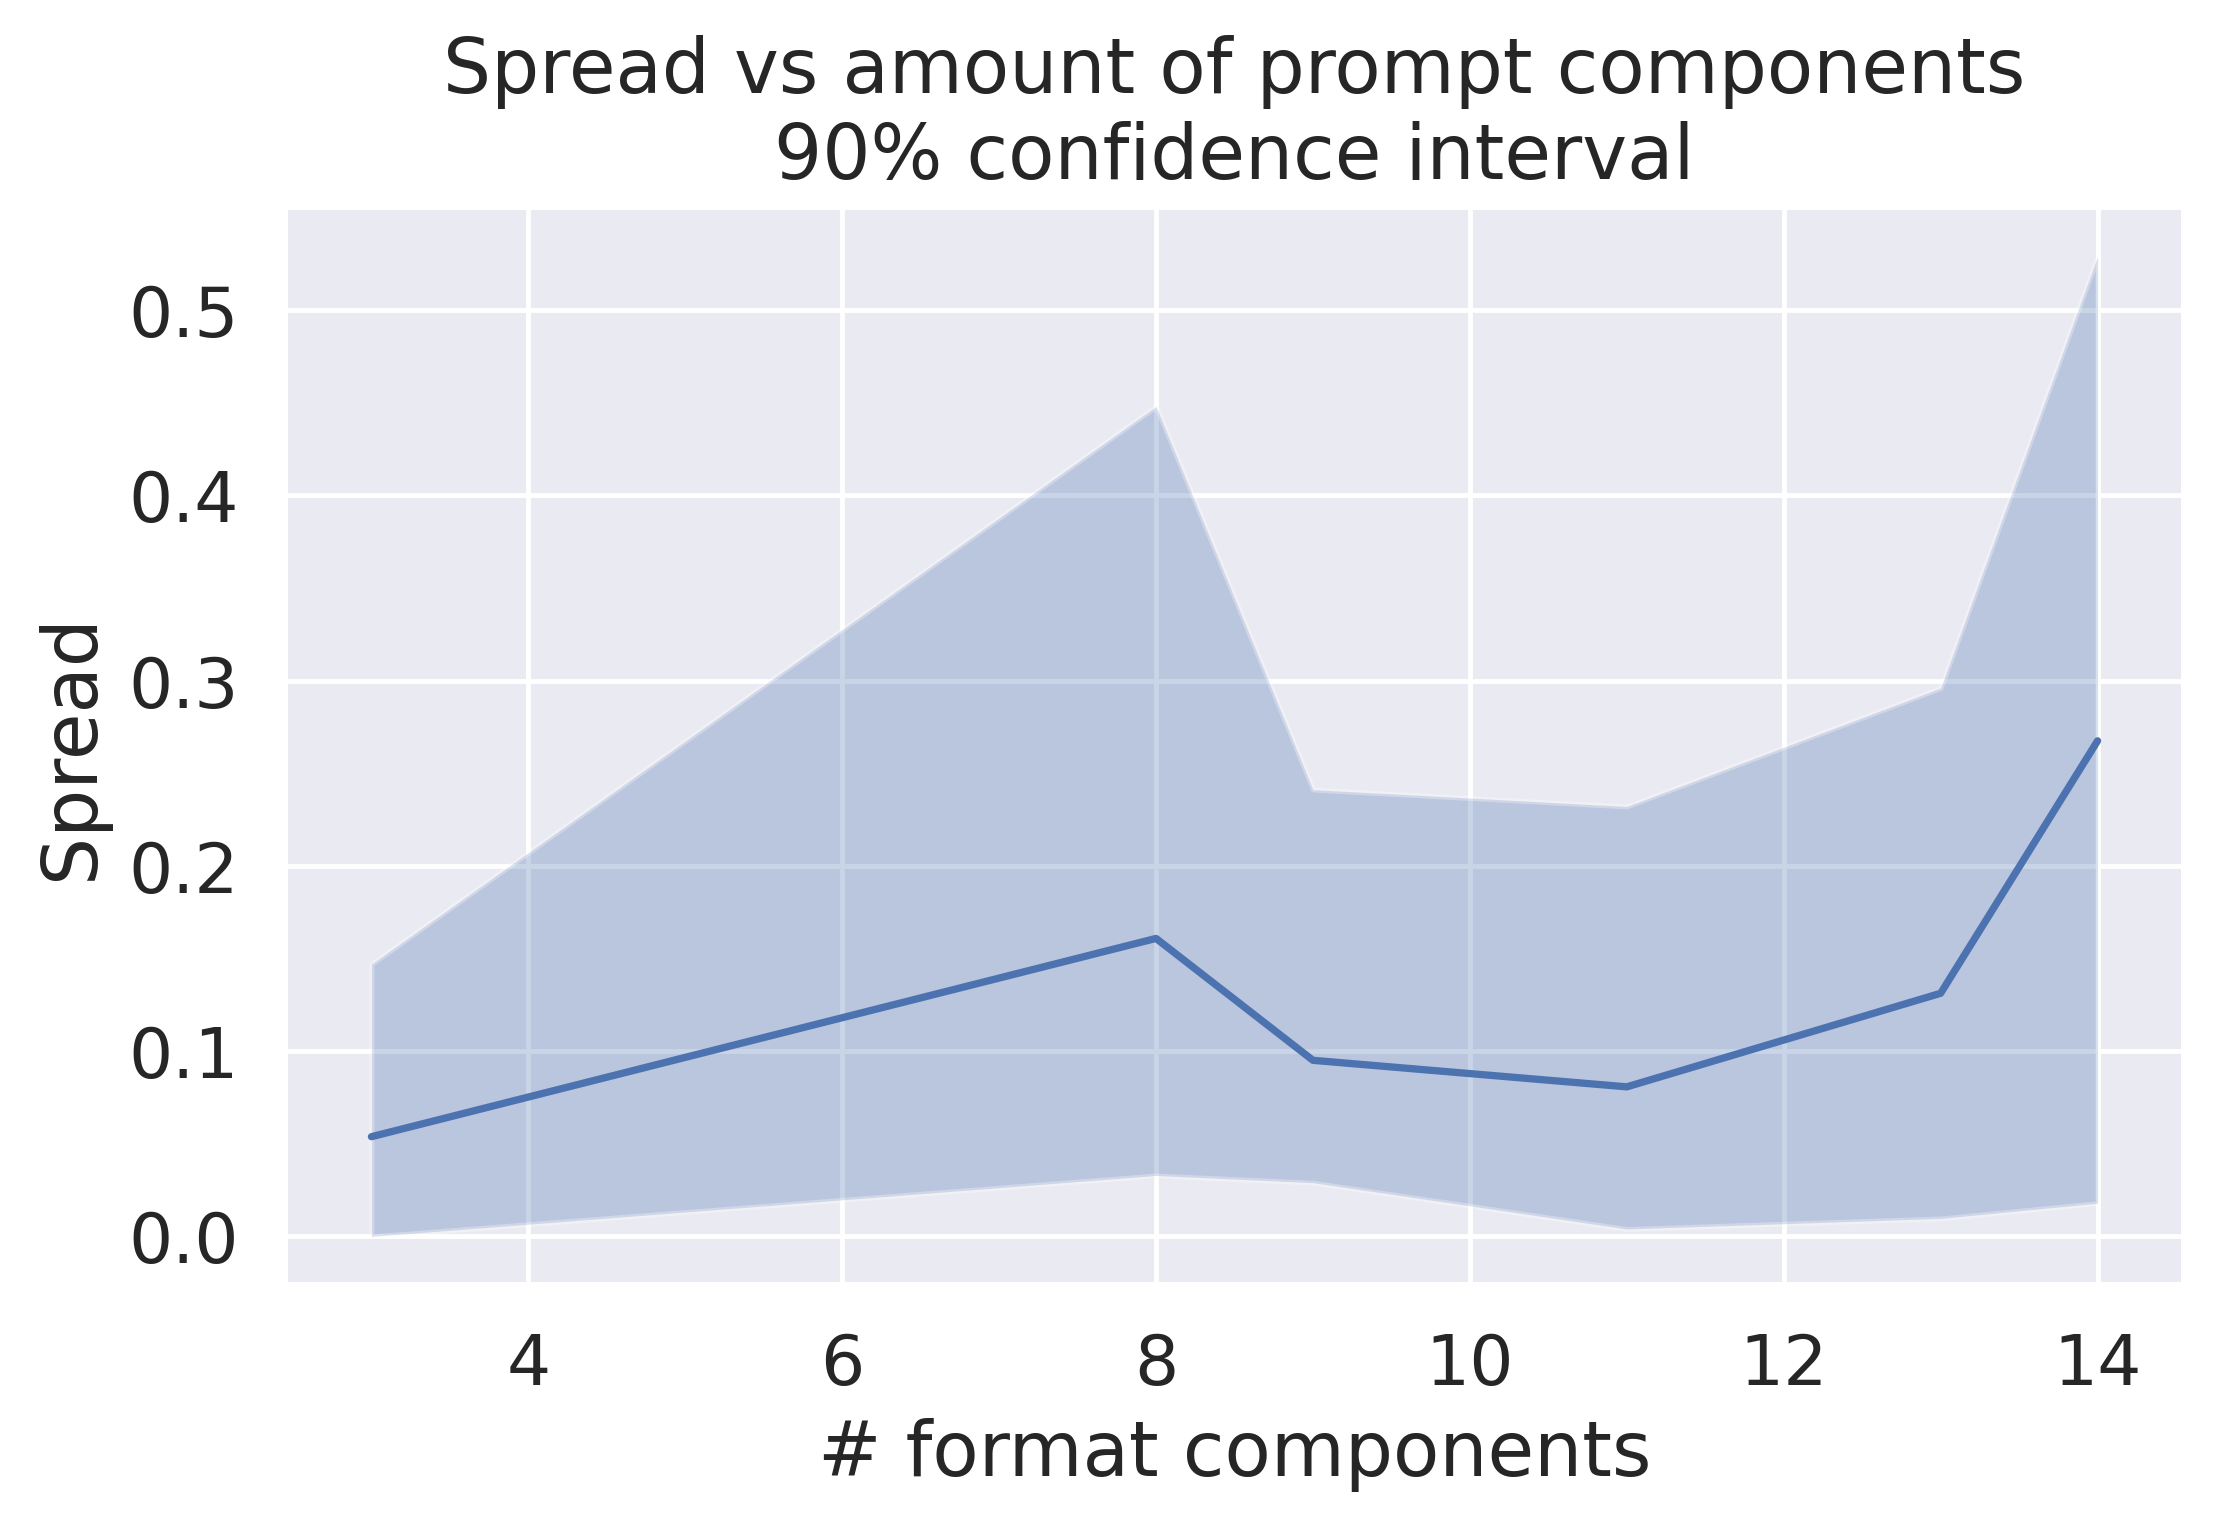

In [60]:
spread_vs_length = df[df["setting"] == "uniform"].groupby("format_length")["spread"].agg(["mean", "std", q05, q95])

plt.figure(figsize=(7, 4), dpi=350)
plt.plot(spread_vs_length.index, spread_vs_length["mean"])
plt.fill_between(
    spread_vs_length.index,
    y1=spread_vs_length["q05"],
    y2=spread_vs_length["q95"],
    alpha=0.3
)
# upper_error = spread_vs_length["q95"] - spread_vs_length["mean"]
# lower_error = spread_vs_length["mean"] - spread_vs_length["q05"]

# plt.errorbar(
#     x=spread_vs_length.index,
#     y=spread_vs_length["mean"],
#     yerr=[lower_error, upper_error],
#     color="black"
# )
plt.xlabel("# format components")
plt.ylabel("Spread")
plt.title("Spread vs amount of prompt components\n90% confidence interval")
plt.savefig("iid_plots/spread_vs_amount_format_components.png", bbox_inches="tight", dpi=350)

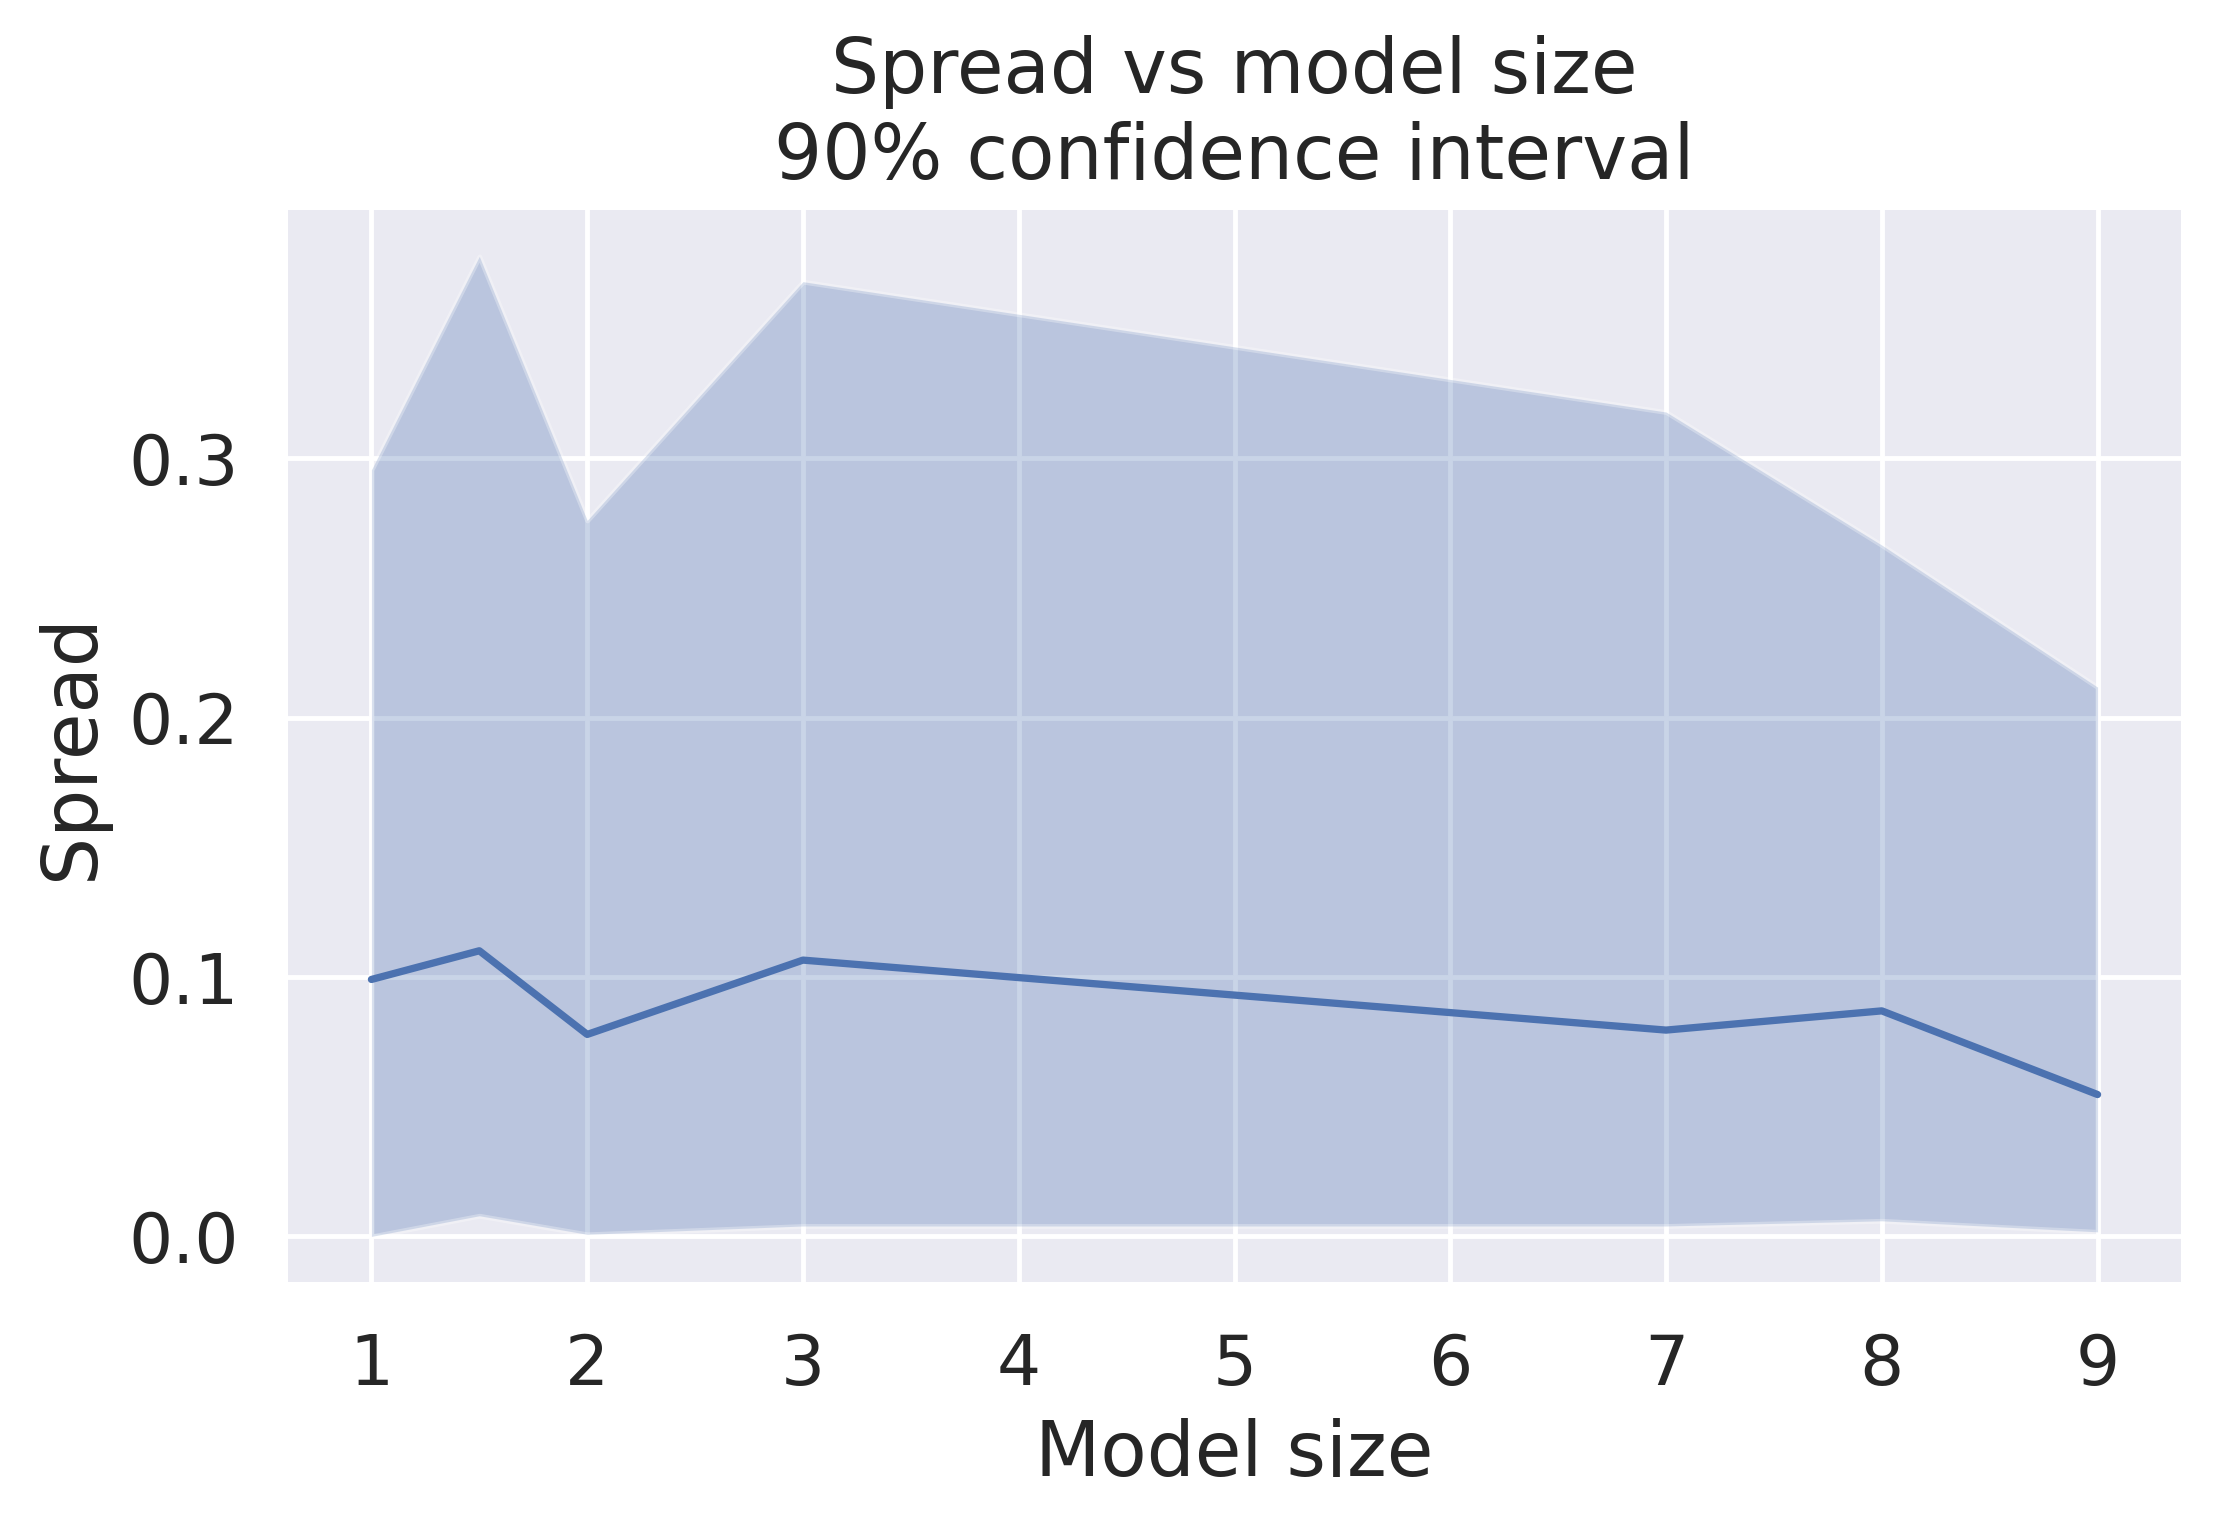

In [6]:
spread_vs_size = df[df["setting"] == "uniform"].groupby("size")["spread"].agg(["mean", q05, q95])

plt.figure(figsize=(7, 4), dpi=350)
plt.plot(spread_vs_size.index, spread_vs_size["mean"])
plt.fill_between(
    spread_vs_size.index,
    y1=spread_vs_size["q05"],
    y2=spread_vs_size["q95"],
    alpha=0.3
)

plt.xlabel("Model size")
plt.ylabel("Spread")
plt.title("Spread vs model size\n90% confidence interval")
plt.savefig("iid_plots/spread_vs_model_size.png", bbox_inches="tight", dpi=350)

### Renaming experiments

In [2]:
from pathlib import Path

root_dir = Path("exp")

for filename in root_dir.glob("*loraconsistency-loss-*"):
    if filename.is_dir():
        new_name = filename.parent / str(filename.name).replace("loraconsistency-loss-", "lora---consistency-")
        filename.rename(new_name)

In [3]:
from pathlib import Path

root_dir = Path("exp")

for filename in root_dir.glob("*-random-*"):
    if filename.is_dir():
        new_name = filename.parent / str(filename.name).replace("-random-", "-iidx2-")
        filename.rename(new_name)

### Experiment with imbalance-robust metrics

In [15]:
import json
import pandas as pd
from pathlib import Path
from typing import Dict
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, accuracy_score

def read_json(path: str) -> Dict:
    with open(path, "r") as f:
        return json.load(f)

In [22]:
# experiment_path = "final_exp/gemma-2-9b-it_lora---iidx2-no-chat-template-response-only-unbalanced-0-shot"
experiment_path = "final_exp/gemma-2-9b-it_lora---iidx2-no-chat-template-response-only-0-shot"

records = []

for name in Path(experiment_path).glob("metadata*.json"):
    result = read_json(name)

    nodes = result["metadata"]["nodes"]
    formats = list(nodes.keys())

    entries = nodes[formats[0]][1]
    y_true = [e["answer"] for e in entries]
    y_pred = [e["generation"] for e in entries]

    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    mattcorr = matthews_corrcoef(y_true, y_pred)

    record = {}
    record["accuracy"] = acc
    record["balanced_accuracy"] = bal_acc
    record["matthews_corrcoef"] = mattcorr
    record["task"] = [piece for piece in name.stem.split("_") if "task" in piece][0]
    records.append(record)

df = pd.DataFrame.from_records(records)

df
# print(f"Metrics:\n  Accuracy: {acc:.2f}\n  Balanced Accuracy: {bal_acc:.2f}\n  Matthew's Correlation: {mattcorr:.2f}")

,accuracy,balanced_accuracy,matthews_corrcoef,task
0,0.965000,0.964960,0.947493,task319
1,0.955000,0.945788,0.929858,task904
2,0.991000,0.992946,0.986897,task158
3,0.734000,0.737005,0.668043,task1419
4,0.694000,0.693919,0.618475,task1423
5,0.786000,0.784474,0.576641,task609
6,0.424000,0.426365,-0.160369,task296
7,0.992000,0.992091,0.984025,task325
8,0.656000,0.651913,0.485918,task580
9,0.925000,0.920312,0.847420,task050


In [26]:
from pathlib import Path

root_dir = Path("final_exp")

# Rename directories containing "-iid-" to use "-iidx2-" instead
for path in root_dir.glob("*-iid-*"):
    new_name = str(path).replace("-iid-", "-iidx2-")
    path.rename(new_name)


In [23]:
df[["accuracy", "balanced_accuracy", "matthews_corrcoef"]].mean()

accuracy             0.836682
balanced_accuracy    0.831586
matthews_corrcoef    0.715143
dtype: float64

In [21]:
df[["accuracy", "balanced_accuracy", "matthews_corrcoef"]].mean()

accuracy             0.788244
balanced_accuracy    0.784279
matthews_corrcoef    0.515502
dtype: float64

In [ ]:
import seaborn as sns

sns.color_palette("Paired")

### Debug prefix masking

In [2]:
import torch
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-3B-Instruct")

def mask_non_predicted(labels, input_ids):
    masked_labels = labels.clone()
    for i in range(len(labels)):
        predicted_indices = (labels[i] != tokenizer.pad_token_id).nonzero(as_tuple=True)[0]

        if len(predicted_indices) > 0:
            first_predicted_idx = predicted_indices[0]
            masked_labels[i, :first_predicted_idx] = -100  # set all content before the predicted part eq -100
        else:
            masked_labels[i, :] = -100  

    return masked_labels



/disk/4tb/seleznev/.conda/envs/aa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
text = "Hello what a beautiful day."
inputs = tokenizer(text, padding="max_length", max_length=16, return_tensors="pt")
inputs

{'input_ids': tensor([[128004, 128004, 128004, 128004, 128004, 128004, 128004, 128004, 128004,
         128000,   9906,   1148,    264,   6366,   1938,     13]]), 'attention_mask': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]])}

In [4]:
tokenizer.pad_token_id

128004

In [5]:
mask_non_predicted(inputs.input_ids, inputs.input_ids)

tensor([[  -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
         128000,   9906,   1148,    264,   6366,   1938,     13]])

### Example of accuracy change

In [ ]:
import pandas as pd
pd.set_option("display.max_colwidth", 100)

spreads = pd.read_csv("exp/Meta-Llama-3.1-8B-Instruct---iidx2-no-chat-template-0-shot/spreads.csv")

spreads = spreads.sort_values("spread", ascending=False)

spreads.head(10)[[
    "task",
    "best_accuracy",
    "worst_accuracy",
    "best_format",
    "worst_format"
]]

In [ ]:
spreads.head(5)[[
    "best_format",
    "worst_format"
]]

### Restructuring experiments dir

In [5]:
import os
from pathlib import Path

model_families = ["falcon", "gemma", "Llama", "Qwen"]
exp_root_dir = Path("exp")

In [ ]:
def restructure_experiments(exp_root_dir, model_families):
    "Assumes shallow structure, with all experiments in `exp` dir."

    # Create directories for each model family with subdirectories
    for family in model_families:
        family_dir = exp_root_dir / family
        family_dir.mkdir(exist_ok=True)
        
        # Create chat template subdirectories
        (family_dir / "chat_template").mkdir(exist_ok=True)
        (family_dir / "no_chat_template").mkdir(exist_ok=True)
        
        # Create setting subdirectories
        (family_dir / "chat_template" / "iid").mkdir(exist_ok=True)
        (family_dir / "chat_template" / "compositional").mkdir(exist_ok=True)
        (family_dir / "no_chat_template" / "iid").mkdir(exist_ok=True)
        (family_dir / "no_chat_template" / "compositional").mkdir(exist_ok=True)

    # Get all directories in exp_root_dir
    exp_dirs_list = [d for d in Path("exp").iterdir() if d.is_dir()]

    # Move directories to their appropriate subfolder based on experiment settings
    for dir_path in exp_dirs_list:
        dir_name = dir_path.name
        # Skip if it's one of the model family directories we just created
        if dir_name in model_families:
            continue
            
        # Check if directory starts with any of the model families
        for family in model_families:
            # if dir_name.startswith(family):
            if family in dir_name:
                # Determine chat template usage
                chat_template_dir = "no_chat_template" if "no-chat-template" in dir_name else "chat_template"
                
                # Determine experiment setting
                setting_dir = "iid" if "iid" in dir_name else "compositional"
                
                # Construct destination path
                dest_path = exp_root_dir / family / chat_template_dir / setting_dir / dir_name
                # Move the directory
                dir_path.rename(dest_path)
                print(f"Moved {dir_name} to {family}/{chat_template_dir}/{setting_dir}/")
                break

restructure_experiments(exp_root_dir, model_families)

In [7]:
def return_shallow_structure():
    for family in model_families:
        for template in ("chat_template", "no_chat_template"):
            for split in ("iid", "compositional"):
                for experiment in (Path(f"exp") / family / template / split).glob("*"):
                    parts = experiment.parts
                    assert parts[-4] == family
                    assert parts[-3] == template
                    assert parts[-2] == split
                    destination = experiment.parent.parent.parent.parent / experiment.name
                    experiment.rename(destination)

return_shallow_structure()

In [5]:
import pandas as pd
pd.set_option("display.width", 1000)
pd.set_option("display.max_colwidth", 300)

def get_family(exp, model_families):
    for family in model_families:
        if exp.startswith(family):
            return family
    return "?"

def get_shots(exp):
    if "2-shot" in exp:
        return "2"
    elif "0-shot" in exp:
        return "0"
    return "?"

def get_method(exp):
    if "lora" in exp and "iidx2" in exp:
        return "lora"
    elif "lora" in exp:
        return "lora_shift"
    elif "default" in exp:
        return "default_format"
    elif "sensitivity-aware-decoding" in exp:
        return "sensitivity-aware-decoding"
    elif "template-ensembles" in exp:
        return "template-ensembles"
    elif "batch-calibration-probs" in exp:
        return "batch-calibration-probs"
    elif "batch-calibration" in exp:
        return "batch-calibration"
    return "none"

def get_size(exp):
    expected_sizes = ["1B", "1.5B", "2b", "3B", "7B", "8B", "9b"]

    for size in expected_sizes:
        if size in exp:
            return size
    
    return "?"

def get_instruct(exp):
    if "Instruct" in exp or "it" in exp:
        return "Instruct"
    return "Base"

In [ ]:
experiments = []

for experiment in exp_root_dir.glob("*"):
    name = experiment.name

    if name in model_families:
        continue

    if "debug" in name or "rank1" in name:
        print(f"Skipping {name}")
        continue

    experiments.append(name)

records = [
    {
        "family": get_family(exp, model_families),
        "size": get_size(exp),
        "instruct": get_instruct(exp),
        "shots": get_shots(exp),
        "template": "no" if "no-chat-template" in exp else "chat-template",
        "split": "iid" if "iid" in exp else "compositional",
        "method": get_method(exp),
        "n_tasks_evaluated": len(list((exp_root_dir / exp).glob("metadataholistic*.json"))),
        "name": exp,
    }
    for exp in experiments
]

df = pd.DataFrame.from_records(records)

In [ ]:
df[
    (df.family == "gemma") & 
    (df.template == "no") & 
    (df["size"] == "2b") & 
    (df.shots.isin(("0", "2"))) & 
    (df.instruct == "Instruct")
].sort_values(["shots", "method"])

### Check number of evaluated tasks & formats 

In [ ]:
import json
from pathlib import Path
from collections import Counter


In [ ]:
for format_split in ("iid", "compositional-separator-space"):
    subdir_path = f"final_exp/{format_split}"
    for cluster in Path(subdir_path).iterdir():
        if not cluster.is_dir():
            continue

        for experiment in cluster.iterdir():
            n_tasks = len(list(experiment.iterdir()))
            print(n_tasks, experiment)

            assert n_tasks == 52, "ERROR"
        

In [ ]:

# exp_dir = Path("exp/Llama-3.2-1B-Instruct_lora---iidx2-no-chat-template-0-shot")
exp_dir = Path("final_exp/iid/base/gemma-2-2b-it---iid-no-chat-template-2-shot")

n_format_evaluated_list = []

for filename in sorted(exp_dir.glob("metadataholistic*.json")):
    with open(filename, "r") as f:
        res = json.load(f)

    n = len(res["all_structured_prompt_formats_accuracies"])
    n_format_evaluated_list.append(n)

    print(n, filename.stem)

# Counter(n_format_evaluated_list)

In [ ]:
for filename in Path("train_test_splits/random").glob("*.json"):
    with open(filename, "r") as f:
        config = json.load(f)

    print(len(config["test_formats"]), filename.stem)

### Renaming "_numnodes_9"

In [ ]:
import os
from pathlib import Path

def rename_files(root_dir):
    # Walk through all directories and files
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if '_numnodes_9_' in filename:
                old_path = os.path.join(dirpath, filename)
                new_filename = filename.replace('_numnodes_9_', '_numnodes_10_')
                new_path = os.path.join(dirpath, new_filename)
                os.rename(old_path, new_path)
                print(f"Renamed: {old_path} -> {new_path}")

# Run the renaming starting from current directory
rename_files('exp')


### Explore amount of formats per task/experiment

In [23]:
import json
from pathlib import Path

path = Path("exp/Llama-3.2-1B-Instruct_lora---simpleanswers-no-chat-template")

def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

formats_evaluated_per_task = []
task_names = []

for filename in sorted(path.glob("*.json")):
    file = load_json(filename)
    n_formats_evaluated = len(file["all_structured_prompt_formats_accuracies"])
    formats_evaluated_per_task.append(n_formats_evaluated)
    tasknum = [part for part in filename.stem.split("_") if "task" in part][0]
    task_names.append(tasknum)

In [ ]:
splits_path = Path("train_test_splits/random")

for filename in sorted(splits_path.glob("*.json")):
    file = load_json(filename)
    tasknum = [part for part in filename.stem.split("_") if "task" in part][0]
    print(tasknum, len(file["test_formats"]))

In [ ]:
from collections import Counter

Counter(formats_evaluated_per_task)

In [ ]:
for n, task in zip(formats_evaluated_per_task, task_names):
    print(task, n)

### Explore class balance in Natural Instructions

In [ ]:
import json
from math import log
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)
%config InlineBackend.figure_format = "svg"

from generate_train_val_test_formats import TASK_NAMES

In [2]:

task_names = set(TASK_NAMES)

def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

answer_counters = []

for path in Path("../natural-instructions/tasks/").glob("*.json"):
    task_num = str(path.stem).split('_')[0]
    if task_num not in task_names:
        continue

    task = load_json(path)

    answers = []
    for instance in task["Instances"]:
        assert isinstance(instance["output"], list) and len(instance["output"]) == 1, f"{path}\n{instance['output']}"
        answers.append(instance["output"][0])

    answer_counters.append(Counter(answers))

In [ ]:
task_sizes = [sum(counter.values()) for counter in answer_counters]

plt.hist(task_sizes)
plt.show()

In [ ]:
sorted(task_sizes)

In [3]:
def relative_entropy(counter):
    freqs = list(counter.values())
    probs = [f / sum(freqs) for f in freqs]
    n = len(probs)

    entropy = sum(-p * log(p) for p in probs)
    max_entropy = log(n)
    return entropy / max_entropy

In [4]:
balancedness = [relative_entropy(c) for c in answer_counters]

In [ ]:
plt.title("Class distribution entropy / (Maximal possible entropy)\nfor 53 tasks in Natural Instructions")
plt.scatter(range(len(balancedness)), balancedness)
plt.ylabel("Entropy / MaxEntropy")
plt.xlabel("Task index") 
plt.show()

### Exploring format structures for tasks

In [ ]:
import json
from pathlib import Path

def load_json(filename):
    with open(filename, "r") as f:
        return json.load(f)

In [2]:
action_type_sequences = []

root_dir = Path("train_test_splits/random")
for filename in root_dir.glob("*"):
    config = load_json(filename)
    action_type_sequences.append(
        (str(filename), config["action_types"])
    )

In [ ]:
max(action_type_sequences, key=lambda x: len(x[1]))

In [4]:
full = [name_seq for name_seq in action_type_sequences if len(set(name_seq[1])) == 6]

In [ ]:
len(full)

In [ ]:
sorted(full, key=lambda name_seq: -len(name_seq[1]))

In [8]:
action_types = ['chosen_space',
   'chosen_item_wrapper',
   'chosen_number_format',
   'chosen_space',
   'chosen_separator',
   'chosen_separator_text_and_option',
   'chosen_space',
   'chosen_space',
   'chosen_item_wrapper',
   'chosen_number_format',
   'chosen_space',
   'chosen_separator',
   'text_descriptor_fn',
   'chosen_separator']

In [ ]:
len(action_types)

### Checking dataset structure

In [ ]:
import pandas as pd

dataset = pd.read_csv("data/df_hermes_superclear.csv")

dataset.head()

### Checking answer probability aggregation

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

from utils import (
    _tokenize_prompts, 
    _tokenize_prompts_with_answers,
    get_ranking_based_generation_single_token_output_classes, 
    get_ranking_based_generation_multiple_token_output_classes
)

In [3]:
model_name = "unsloth/Llama-3.2-1B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
tokenizer("once upon a time...", add_special_tokens=False)["input_ids"]

In [ ]:
batch_size = 2
seq_len = 5
vocab_size = 128

logits = torch.arange(batch_size * seq_len * vocab_size).reshape(batch_size, seq_len, vocab_size).float()
logits = logits / logits.numel()
tokens = torch.randint(0, vocab_size, size=(batch_size, seq_len))

torch.gather(logits, dim=-1, index=tokens[..., None]).squeeze()

In [ ]:
manual = torch.empty(batch_size, seq_len)

for i in range(batch_size):
    for j in range(seq_len):
        manual[i, j] = logits[i, j, tokens[i, j]]

manual

In [ ]:
cumul_log_probs = torch.arange(2 * 3)

cumul_log_probs.reshape(2, 3)

In [ ]:
tokenizer.special_tokens_map

In [9]:
special_tokens_dict = {'pad_token': '<pad>'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
tokenizer.padding_side = "left"

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    cache_dir="/disk/4tb/seleznev/.cache/huggingface",
    # local_files_only=True,
    torch_dtype=torch.bfloat16
).eval().cuda()

model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id
model.generation_config.pad_token_id = tokenizer.pad_token_id

### Checking single token ranking function

In [15]:
prompts = [
    "Question: 2+2 equals?\nChoose correct option: A) 3 B) 4 C) 5.\nRespond with a single letter.",
    "Question: Is an elephant heavier than a mouse?\nChoose correct option:  A) yes B) no C) sometimes.\nRespond with in a single letter.",
    "Question: A synonim for the word 'rapid'?\nChoose correct option:  A) slow B) fast C) rap.\nRespond with in a single letter."
]

output_classes = ["A", "B", "C"]

In [ ]:
generation = get_ranking_based_generation_single_token_output_classes(prompts, output_classes, tokenizer, model)

In [ ]:
generation

In [ ]:
prompt = "2 + 2 = "

out = model.generate(**tokenizer(prompt, return_tensors="pt").to("cuda"), max_new_tokens=10)

generations = tokenizer.batch_decode(out)

for g in generations:
    print(g)

In [ ]:
prompt = prompts[1]

input_ids = tokenizer.apply_chat_template(
    [{"role": "user", "content": prompt}], 
    return_tensors="pt"
).to("cuda")

out = model.generate(input_ids, max_new_tokens=10)

generations = tokenizer.batch_decode(out)

for g in generations:
    print(g)

### Checking multi-token ranking function

In [14]:
prompts = [
    "Question: 2+2 equals? Choose correct option.\nOption 1: 3 Option 2: 4 Option 3: 5.",
    "Question: Is an elephant heavier than a mouse? Choose correct option.\nOption 1: yes Option 2: no Option 3: sometimes.",
    "Question: A synonim for the word 'rapid'? Choose correct option.\nOption 1: slow Option 2: fast Option 3: rap."
]

output_classes = ["Option 1", "Option 2", "Option 3"]

In [ ]:
generation = get_ranking_based_generation_multiple_token_output_classes(prompts[0], output_classes, tokenizer, model, batch_size_llm=2)

In [ ]:
generation

### Checking chat templating

In [ ]:
tokenizer.chat_template

In [11]:
special_tokens_dict = {'pad_token': '<pad>'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
tokenizer.padding_side = "left"

In [12]:
prompts = [
    "Q: Do pigs fly? (yes or no)\nA:",
    "Q: Is Everest higher than 9000 meters? (yes or no)\nA:",
    "Q: Is 2 + 2 = 4 correct? (yes or no):\nA:"
]

In [13]:
answers = ["yes", "no"]

In [14]:
inputs = _tokenize_prompts_with_answers(prompts, answers, tokenizer)

In [ ]:
inputs.input_ids.shape

In [ ]:
padded_text = tokenizer.batch_decode(inputs if isinstance(inputs, torch.Tensor) else inputs.input_ids)

for text in padded_text:
    print(text)
    print("="*30)